In [35]:
!nvidia-smi

Sat Mar 19 13:05:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 398.35                 Driver Version: 398.35                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060   WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   74C    P8     6W /  N/A |     92MiB /  6144MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Importation des données et ResNet50

$\underline{Importation}$

On commence par importer les packages nécessaires pour le deep learning. On fera intervenir une architecture de réseau qui est connu : ResNet50 

In [36]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from utils.canvas_embedding import *

In [37]:
image_size = (224,224)

train_data_dir = 'C:/Users/na_to/OneDrive/Bureau/Insa/Mapromo/ML3/Exercices/Data/chihuahua-vs-muffin/train'
validation_data_dir = 'C:/Users/na_to/OneDrive/Bureau/Insa/Mapromo/ML3/Exercices/Data/chihuahua-vs-muffin/validation'
test_data_dir = 'C:/Users/na_to/OneDrive/Bureau/Insa/Mapromo/ML3/Exercices/Data/chihuahua-vs-muffin/test' 
batch_size = 16

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical'
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    validation_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical'
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode = 'categorical'
)

Found 568 files belonging to 2 classes.
Found 142 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


    On a 568 images dans le train avec 2 classes muffin et chihuahua.
    On a 142 images dans la validation avec 2 classes muffin et chihuahua
    On a 16 images dans la validation avec 2 classes muffin et chihuahua

$\underline{ResNet-50}$

ResNet-50 est un réseau neuronal convolutif de 50 couches de profondeur. On peut charger une version pré-entraînée du réseau formée sur plus d'un million d'images à partir de la base de données ImageNet. Le réseau pré-entraîné peut classer les images en 1000 catégories d'objets.  Le réseau a une taille d'entrée d'image de 224 par 224 

In [43]:
# create the base pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False)

    weights='imagenet' : pré-entrainement sur les images de ImageNet. On charge les poids du réseau ResNet50
    Include_top = False : On n'inclut pas les 3 couches entièrement connectées à la fin du réseau. 
    On souhaite juste prédire 2 classes: chihuahua et muffin

On peut afficher la structure de l'architecture ci-dessous

In [44]:
print(base_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Le modèle compte au total 23,587,712 paramètres. Parmi les couches présent dans le réseau on peut apercevoir par exemple le MaxPooing2D, ZeroPadding2D, BatchNormalzation et les fonctions d'activations.

$\underline{Data\_augmentation}$

On augmente notre jeux de données avec les modifications ci-dessous sur les images qu'on ajoutera dans notre réseau.

In [46]:
img_augmentation = keras.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

On ajoute de nouvelle données avec les modifications suivantes : 

    -On effectue une légère rotation sur l'image.
    -On effectue une translation sur l'image:
        height_factor : représentant les limites inférieure et supérieure pour le déplacement vertical. 
        width_factor : représentant les limites inférieure et supérieure pour le décalage horizontal. 
    -Retourne les images de manière aléatoire
    -On ajoute de faible constrast

# Modélisation

$\underline{couche\_gelée}$

In [60]:
inputs = layers.Input(shape=(224,224, 3))
x = preprocess_input(inputs)
x = img_augmentation(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5, name='avg_pool_dropout')(x)
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

optimizer = Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

On commence par apprend la tête du réseau en gélant les couches du réseau pré-entrainé avec layer.trainable = False


Pour les dernières couches on ajoute : 
        
        - GlobalAveragePooling2D : Prend un tenseur de taille (largeur d'entrée) x (hauteur d'entrée) x (canaux d'entrée) et calcule la valeur moyenne de toutes les valeurs sur l'ensemble de la matrice (largeur d'entrée) x (hauteur d'entrée) pour chacun des (canaux d'entrée)
        - Couche dense avec comme fonction d'activation relu 
        - On ajoute un dropout de 50% : 50% des neurones ont des réseaux inactifs.
        - On ajoute une couche de sortie avec comme fonction d'activation softmax : qui nous sort la probabilité d'obtenir à un chiuahua et un muffin.
        
On utilise algorithme d'adam comme optimiseur

In [61]:
n_epochs = 5
hist = model.fit(train_ds.repeat(), epochs=n_epochs, steps_per_epoch= 10, validation_data=val_ds)

Epoch 1/5
10/10 [==============================] - 24s 2s/step - loss: 0.3619 - accuracy: 0.9375 - val_loss: 0.7428 - val_accuracy: 0.9789
Epoch 2/5
10/10 [==============================] - 20s 2s/step - loss: 1.3962 - accuracy: 0.9688 - val_loss: 0.3907 - val_accuracy: 0.9930
Epoch 3/5
10/10 [==============================] - 19s 2s/step - loss: 0.0776 - accuracy: 0.9875 - val_loss: 0.9603 - val_accuracy: 0.9859
Epoch 4/5
10/10 [==============================] - 19s 2s/step - loss: 2.1480 - accuracy: 0.9737 - val_loss: 3.2125 - val_accuracy: 0.9718
Epoch 5/5
10/10 [==============================] - 19s 2s/step - loss: 0.2663 - accuracy: 0.9875 - val_loss: 1.4195 - val_accuracy: 0.9789


In [62]:
model.evaluate(val_ds)

9/9 [==============================] - 9s 915ms/step - loss: 1.4195 - accuracy: 0.9789


[1.4195181131362915, 0.9788732528686523]

En évaluant notre modèle, on observe bien un accuracy bien elevé qui est de 0.9859

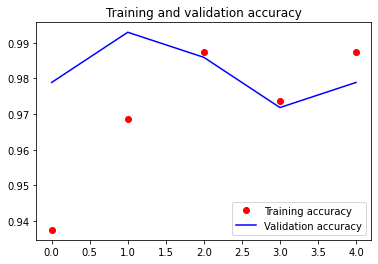

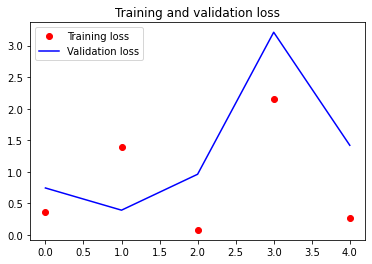

In [63]:
accuracy = hist.history["accuracy"]
val_accuracy = hist.history["val_accuracy"]
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'ro', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

On peut observer quelques fluctuation sur les graphique de fonction de perte et d'accuracy

In [64]:
model.evaluate(test_ds)

1/1 [==============================] - 1s 971ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

En évaluant notre modèle, on observe un accuracy parfait de 1 pour le test. On a que 16 images dans le test et il s'agit d'un réseau très perfomant, il est donc normal d'obtenir un score parfait.

$\underline{couche\_gelée\_et\_dégelée}$

On va maintenant gelée et ddegelée une partie des couches du reseau.

In [65]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_10
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_b

On observe qu'on a plus de 175 couches dans notre réseau. On peut voir tous les noms des couches

In [67]:
from tensorflow.keras import layers

for layer in base_model.layers[:81]:
    layer.trainable = False
for layer in base_model.layers[81:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

epochs = 10
hist_bis = model.fit(train_ds, epochs=n_epochs, validation_data=val_ds)

Epoch 1/5
36/36 [==============================] - 137s 4s/step - loss: 1.7345 - accuracy: 0.9771 - val_loss: 7.7198 - val_accuracy: 0.9155
Epoch 2/5
36/36 [==============================] - 145s 4s/step - loss: 1.5189 - accuracy: 0.9665 - val_loss: 0.6605 - val_accuracy: 0.9859
Epoch 3/5
36/36 [==============================] - 144s 4s/step - loss: 0.6904 - accuracy: 0.9525 - val_loss: 0.3239 - val_accuracy: 0.9648
Epoch 4/5
36/36 [==============================] - 145s 4s/step - loss: 0.1051 - accuracy: 0.9877 - val_loss: 0.1699 - val_accuracy: 0.9789
Epoch 5/5
36/36 [==============================] - 142s 4s/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 0.0808 - val_accuracy: 0.9930


On reapprend l'ensemble du réseau en gélant les 81 premiers couches du réseau et en dégélant les couches suivantes.

In [68]:
model.evaluate(val_ds)

9/9 [==============================] - 15s 2s/step - loss: 0.0808 - accuracy: 0.9930


[0.08079501241445541, 0.9929577708244324]

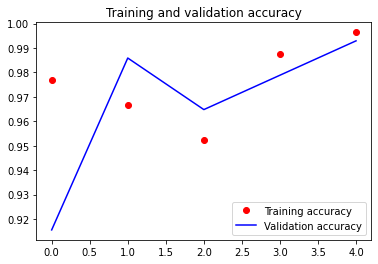

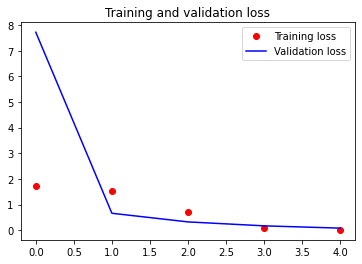

In [69]:
accuracy_bis = hist_bis.history["accuracy"]
val_accuracy_bis = hist_bis.history["val_accuracy"]
loss_bis = hist_bis.history['loss']
val_loss_bis = hist_bis.history['val_loss']
epochs_bis = range(len(accuracy_bis))
plt.plot(epochs_bis, accuracy_bis, 'ro', label='Training accuracy')
plt.plot(epochs_bis, val_accuracy_bis, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs_bis, loss_bis, 'ro', label='Training loss')
plt.plot(epochs_bis, val_loss_bis, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Sur le graphique on peut apercevoit des améliorations comparé à la précédente. Les fonctions de pertes ont tendance à se stabilisés.
De même, pour les valeurs d'accuracy, qui deviennent de plus en plus en plus performant après l'epoch 2. 

In [70]:
model.evaluate(test_ds)

1/1 [==============================] - 2s 2s/step - loss: 0.0020 - accuracy: 1.0000


[0.0020433147437870502, 1.0]

On obtient toujours un score parfait, un accuracy de 1 lorsqu'on évalue sur les données de test.

Même si on a un accuracy similaire, ce modèle à l'air plus performant que la précédente, lorsqu'on avait gelée toutes les couches du réseau pré-entrainé.

# TSNE

$\underline{Visualation\_validation\_train}$ 

In [77]:
train_ds = keras.preprocessing.image_dataset_from_directory(train_data_dir, image_size=image_size, batch_size=batch_size, label_mode = 'categorical', shuffle=False)
val_ds = keras.preprocessing.image_dataset_from_directory(validation_data_dir, image_size=image_size, batch_size=batch_size, label_mode = 'categorical', shuffle=False)

Found 568 files belonging to 2 classes.
Found 142 files belonging to 2 classes.


In [78]:
inputs = layers.Input(shape=(224,224, 3))
x = preprocess_input(inputs)
x = base_model(x)
bottleneck_features = layers.GlobalAveragePooling2D()(x)
bottleneck_model = Model(inputs = inputs, outputs=bottleneck_features)

In [79]:
train_data_processed = bottleneck_model.predict(train_ds)
test_data_processed = bottleneck_model.predict(val_ds)

train_labels = np.concatenate([label for data, label in train_ds], axis=0)
test_labels = np.concatenate([label for data, label in val_ds], axis=0)

train_data = np.concatenate([data for data, label in train_ds], axis=0)
test_data = np.concatenate([data for data, label in val_ds], axis=0)


In [80]:
data = np.concatenate((train_data,test_data))
data_processed = np.concatenate((train_data_processed,test_data_processed))
targets = np.concatenate((train_labels, test_labels))

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csgraph
from sklearn.manifold import TSNE

embedding = TSNE()
data_umaped = embedding.fit_transform(data_processed)

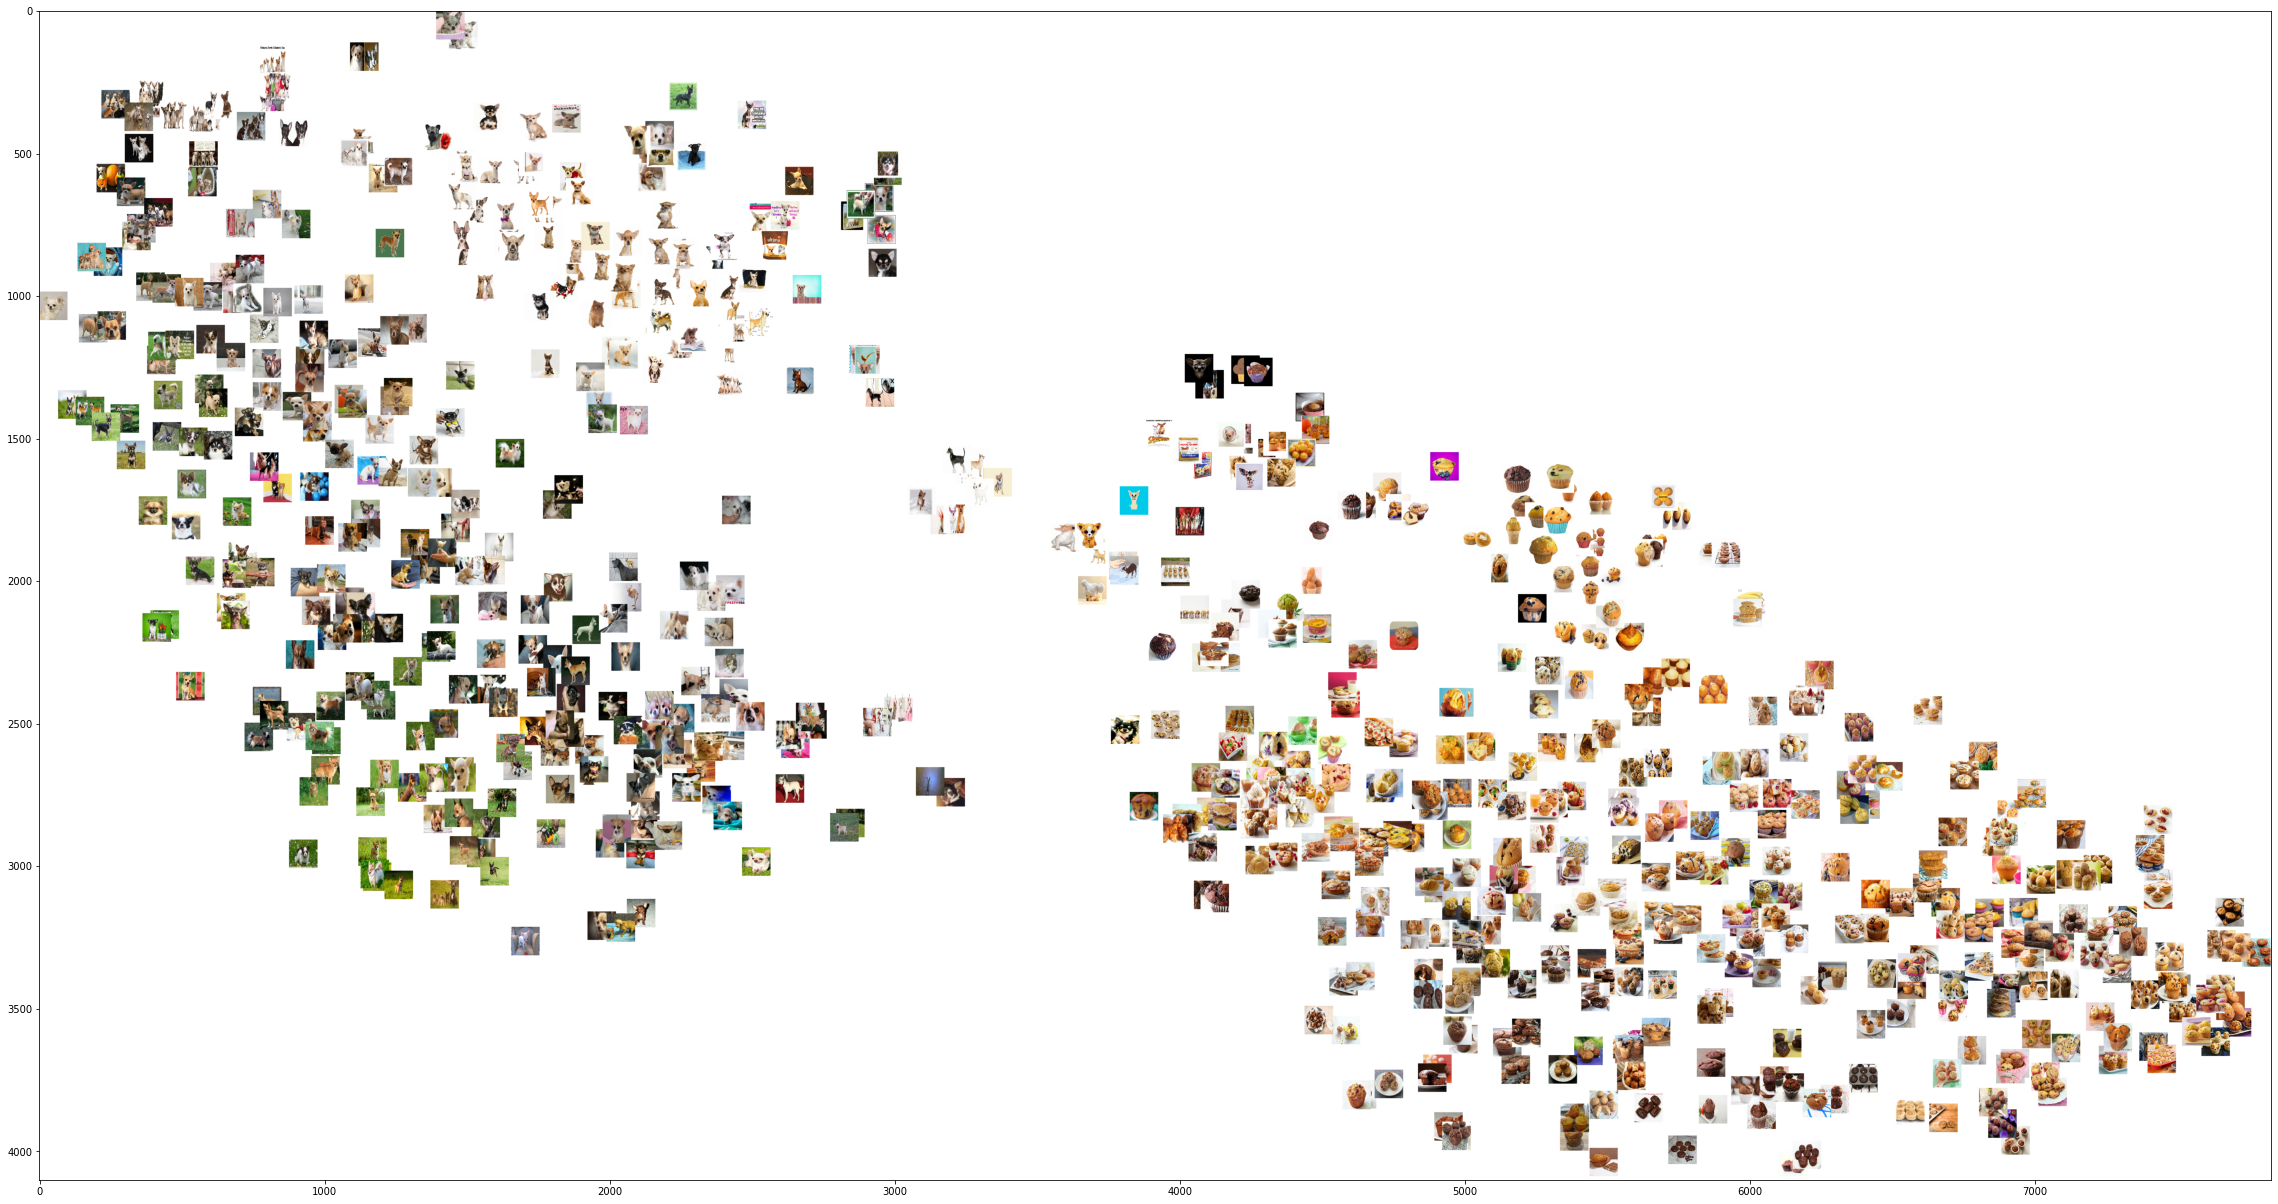

In [29]:
canvas_umap = image_scatter(data_umaped,data,100)
plt.figure(figsize=(40,40))
plt.imshow(canvas_umap)

Sur le schèma on peut distinguer deux groupes (à gauche et à droite). On affiche les images qui ont été classé par le modèle.

$\underline{Visualation\_test\_train}$ 

In [82]:
test_ds = keras.preprocessing.image_dataset_from_directory(test_data_dir, image_size=image_size, batch_size=batch_size, label_mode = 'categorical', shuffle=False)

Found 16 files belonging to 2 classes.


In [83]:
vrai_test_data_processed = bottleneck_model.predict(test_ds)

In [84]:
vrai_test_labels = np.concatenate([label for data, label in test_ds], axis=0)

In [85]:
vrai_test_data = np.concatenate([data for data, label in test_ds], axis=0)

In [86]:
data_bis = np.concatenate((train_data,vrai_test_data))
data_processed_bis = np.concatenate((train_data_processed,vrai_test_data_processed))
targets_bis = np.concatenate((train_labels, vrai_test_labels))

In [ ]:
data_umaped_bis = embedding.fit_transform(data_processed_bis)

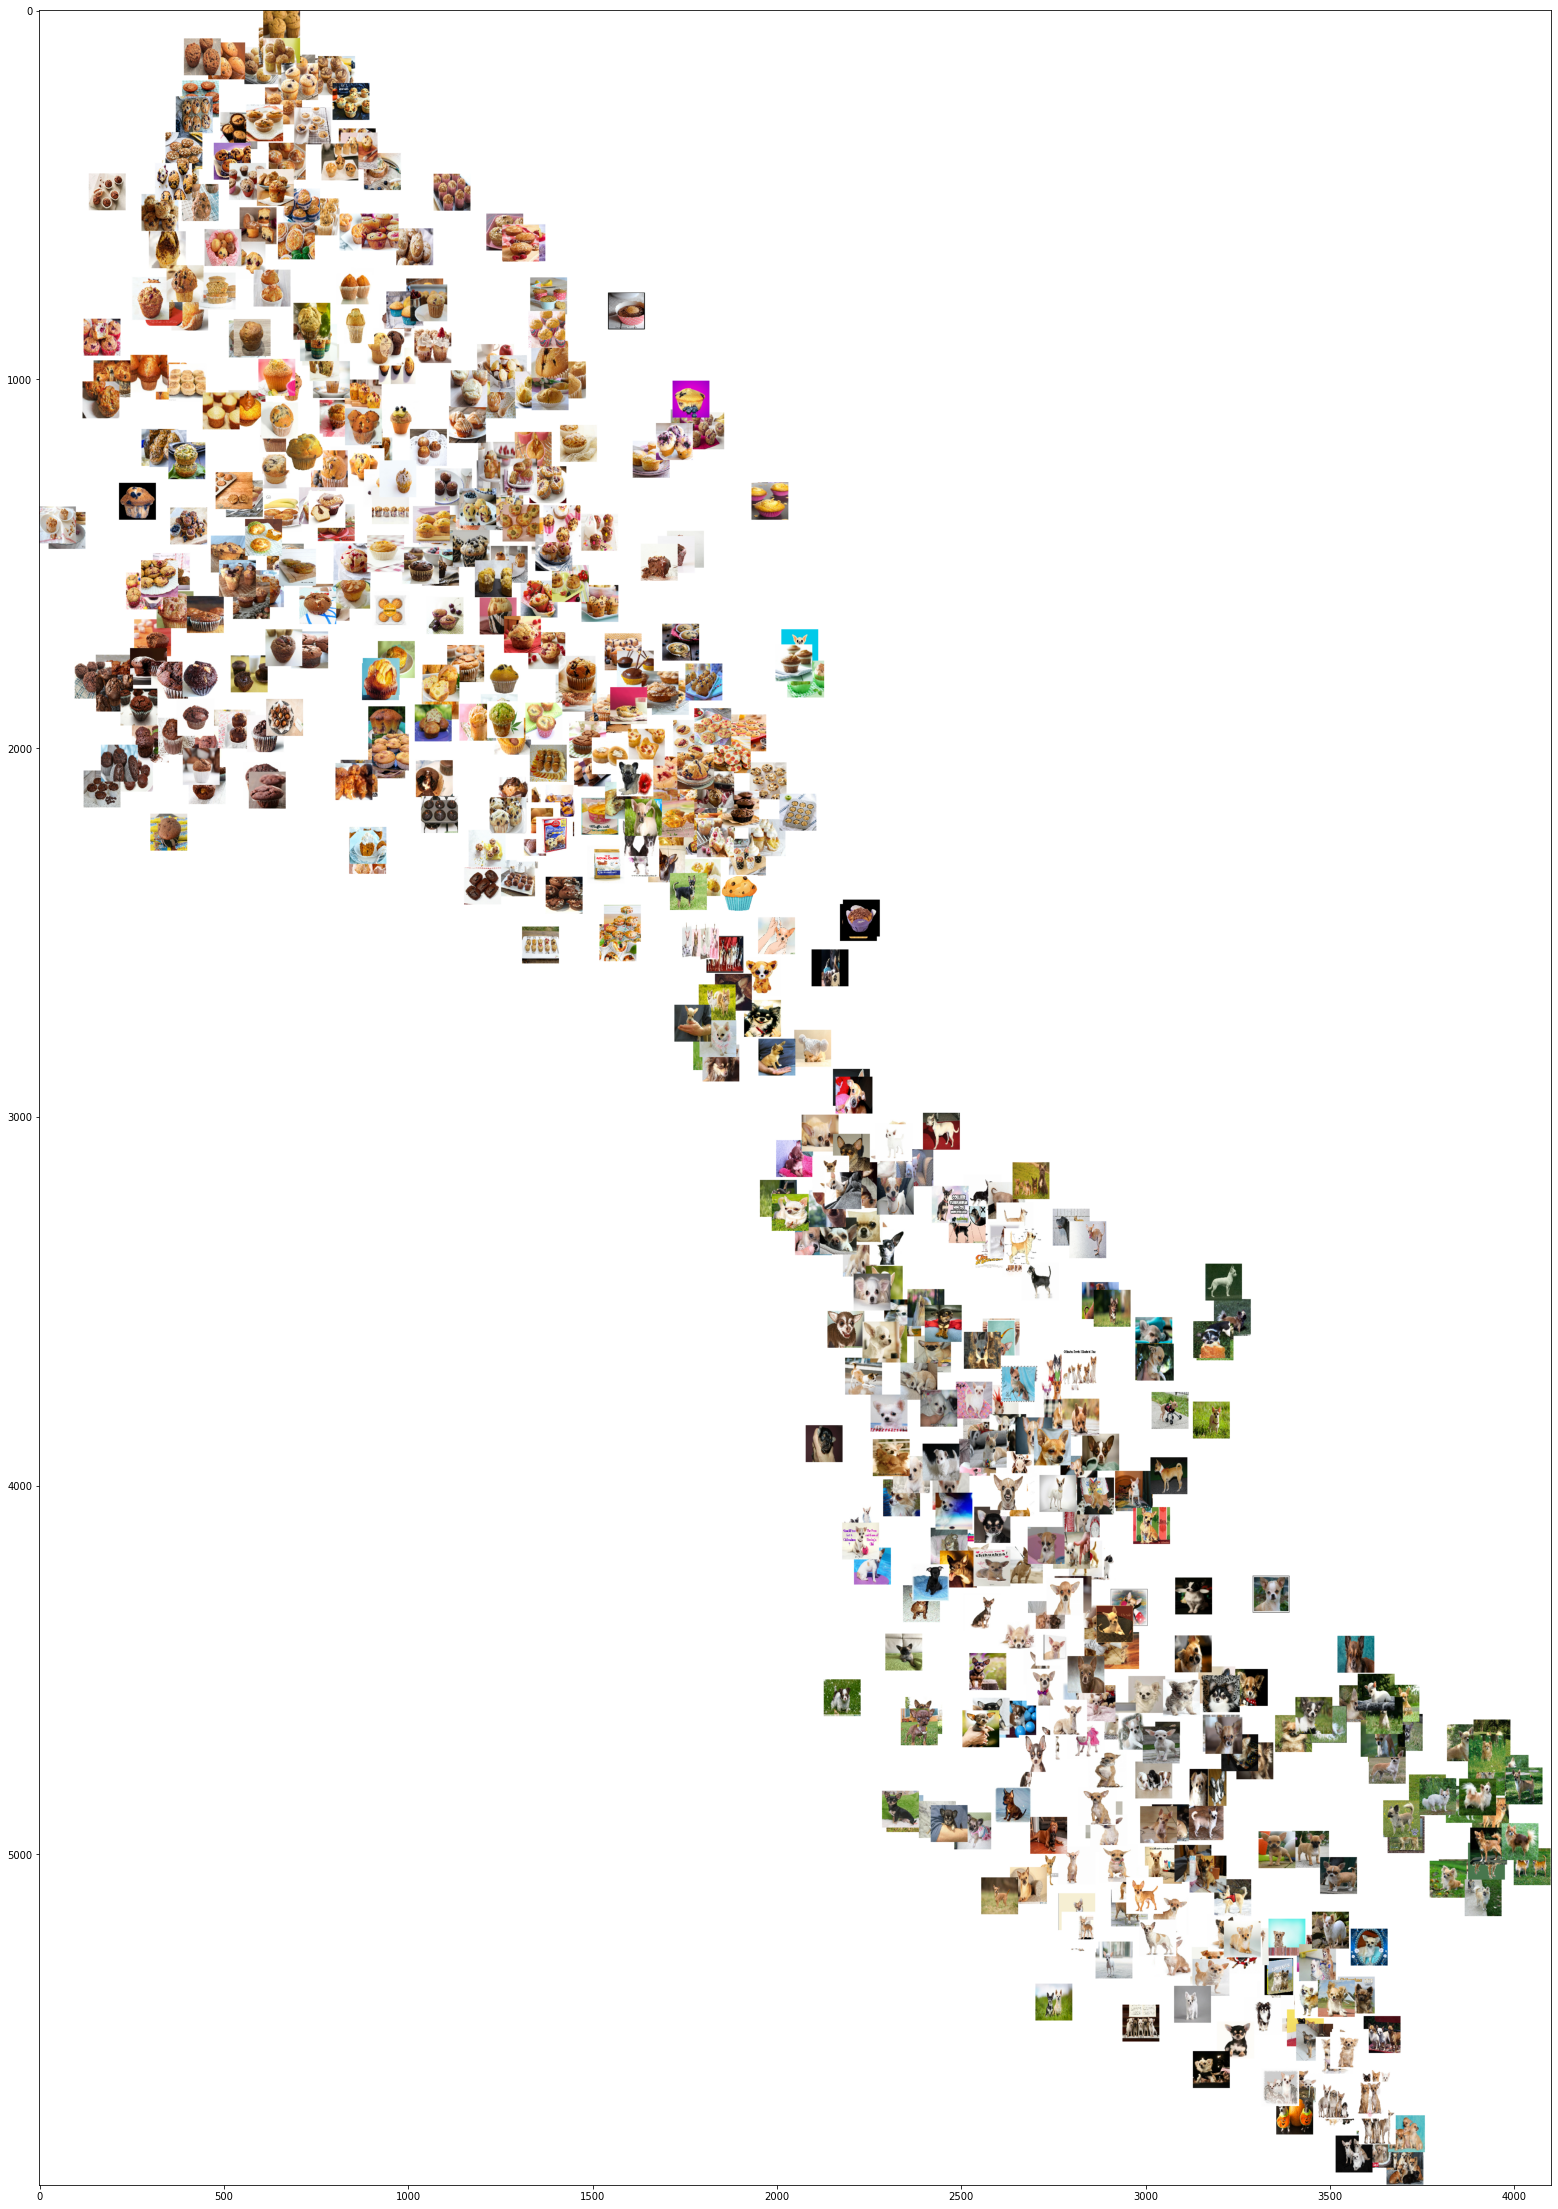

In [88]:
canvas_umap_bis = image_scatter(data_umaped_bis,data,100)
plt.figure(figsize=(40,40))
plt.imshow(canvas_umap_bis)

Tous les images de Test ont été bien classé par le modèle. On peut distinguer deux classes (en haut à gauche et en bas à droite).